Assignment 1, PHYS7332, Fall 2024 -- Mostafa Alkady

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Question 3:

Parts (a) and (b): A function that implements <b>Katz centrality</b>, augmented with error handling: <br> 
* Please note that in Katz centrality, if a graph has no connectivity (consists of isolated nodes), then it's adjacency matrix will be zero and so will be all of its eigenvalues. In the calculation below, we divide 1/max(eigenvalue). Hence, both parts (iii) and (iv) in the question are equivalent and can be tested by the same line of code.

In [105]:
def katz_centrality(G, node, beta = 1):
    '''
    A function that calculates the Katz centrality of a node in a graph.

    Input:
    G (nx.Graph): a networkx graph
    node (int): a node in the graph G

    Output:
    x (float): the Katz centrality of the node
    '''
    if not isinstance(G, nx.Graph): # assert that the input is a networkx graph (ii)
        raise TypeError(f"The graph is expected to be a Networkx object, but got {type(G).__name__} instead.")

    if len(G) == 0: # assert that the graph is not empty
        raise ValueError("The graph is empty.")

    if node not in G.nodes(): # assert that the node is in the graph (i)
        raise ValueError("Node not in graph.")

    np.random.seed(42)
    n = G.number_of_nodes()
    A = nx.adjacency_matrix(G).todense()
    I = np.eye(n)

    try: # assert that the adjacency matrix has positive eigenvalues (iii) & (iv)
        alpha = np.random.uniform(0, 1 / max(np.linalg.eigvals(A))) # any value less than 1 / highest eigenvalue
    except Exception as e:
        raise ValueError("The adjacency matrix has no eigenvalues.")

    x = beta * np.linalg.inv(I - alpha * A) @ np.ones(n)
    return x[node]

### ANOTHER VERSION OF THE FUNCTION THAT RETURNS A DICTIONARY ###

def katz_centrality_return_dict(G, alpha = 0.1, beta = 1):
    '''
    A function that calculates the Katz centrality for a graph and returns a dict.

    Input:
    G (nx.Graph): a networkx graph
    node (int): a node in the graph G

    Output:
    centraity (dict): a dict for each node and its Katz centrality
    '''
    if not isinstance(G, nx.Graph): # assert that the input is a networkx graph (ii)
        raise TypeError(f"The graph is expected to be a Networkx object, but got {type(G).__name__} instead.")

    if len(G) == 0: # assert that the graph is not empty
        raise ValueError("The graph is empty.")

    np.random.seed(42)
    n = G.number_of_nodes()
    A = nx.adjacency_matrix(G).todense()
    I = np.eye(n)

    try: # assert that the adjacency matrix has positive eigenvalues (iii) & (iv)
        if 0.1 > 1 / max(np.linalg.eigvals(A)):
            alpha = np.random.uniform(0, 1 / max(np.linalg.eigvals(A))) # any value less than 1 / highest eigenvalue
        else:
            alpha = 0.1
    except Exception as e:
        raise ValueError("The adjacency matrix has no eigenvalues.")

    x = beta * np.linalg.inv(I - alpha * A) @ np.ones(n)

    # normalize the centrality such that the square of the centrality sums to 1 (as in the networkx implementation)
    x = x / np.sqrt(sum(x**2))
    return {node: x[node] for node in G.nodes()}

Part (c): Testing against Networkx Implementation

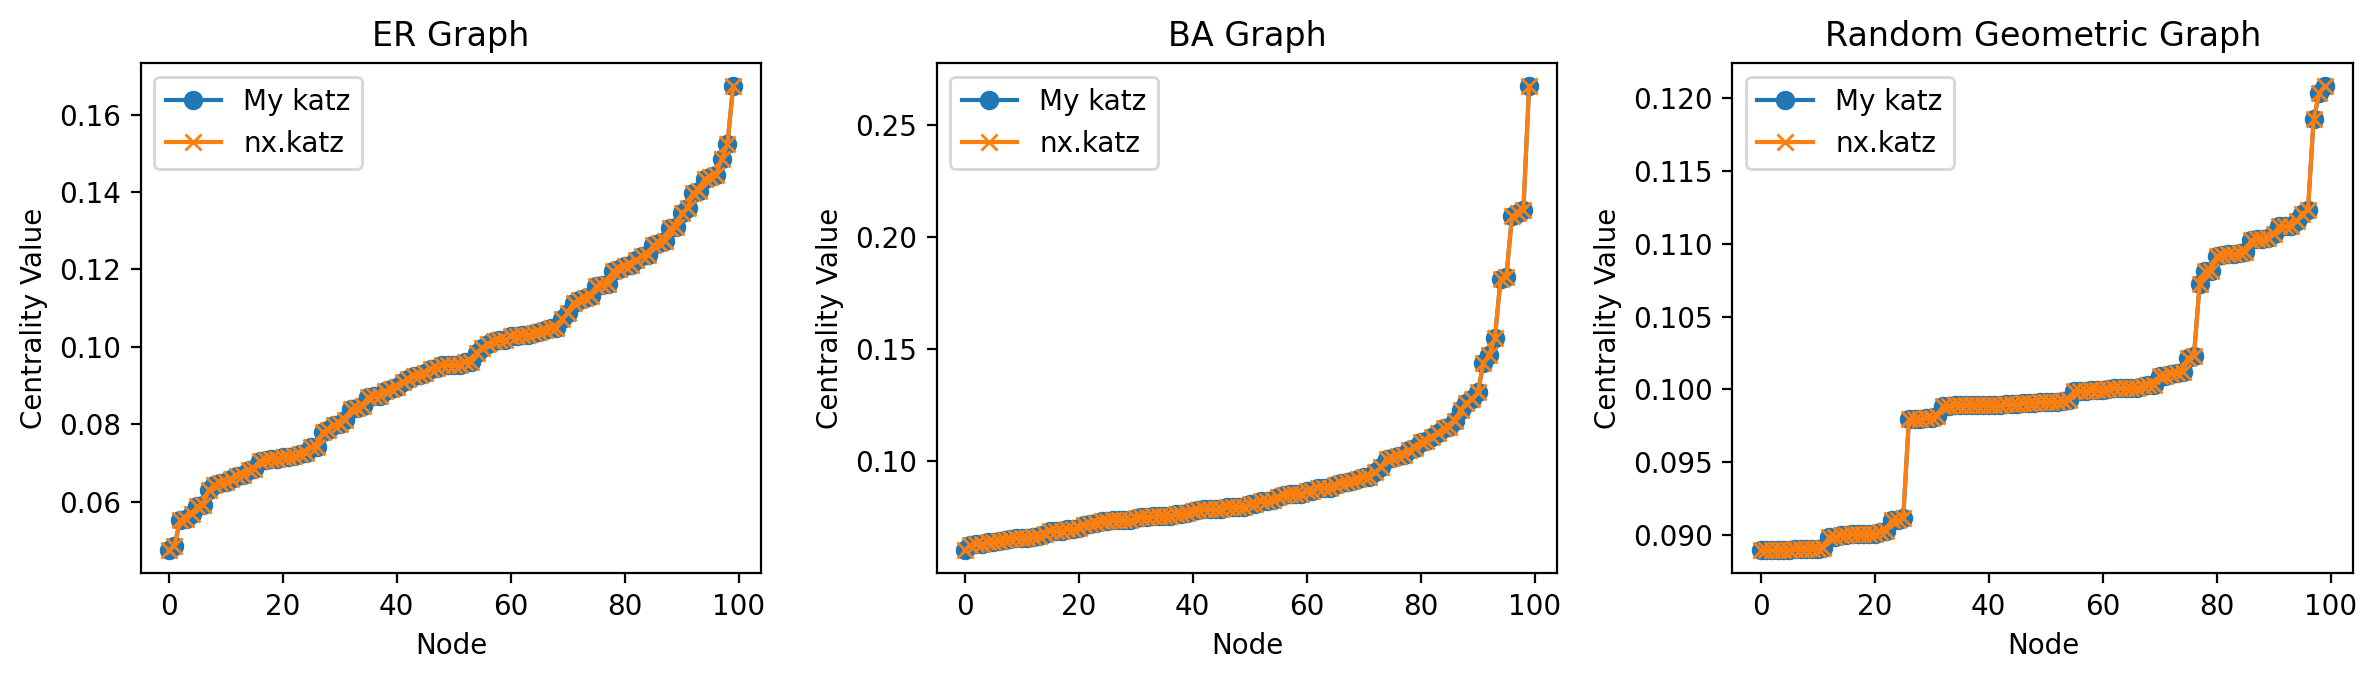

In [109]:
G1 = nx.erdos_renyi_graph(n=100, p=0.05)
G2 = nx.barabasi_albert_graph(100, 2)
G3 = nx.watts_strogatz_graph(100, 3, 0.3)

Graphs = [G1, G2, G3]

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3.5),dpi=200)
plot_titles = ['ER Graph', 'BA Graph', 'Random Geometric Graph']
y_axes = ['Centrality Value'] * 3

for i in range(len(Graphs)):
    G = Graphs[i]
    my_katz_centrality = katz_centrality_return_dict(G)
    my_katz_values = sorted(my_katz_centrality.values())
    nx_katz_centrality = nx.katz_centrality(G, alpha=0.1, beta=1.0)
    nx_katz_values = sorted(nx_katz_centrality.values())
    ax = [ax1, ax2, ax3][i]
    ax.plot(my_katz_values, label="My katz", marker='o')
    ax.plot(nx_katz_values, label="nx.katz", marker='x')
    ax.set_title(plot_titles[i])
    ax.set_ylabel(y_axes[i])
    ax.set_xlabel('Node')
    ax.legend()
plt.tight_layout()
# plt.figure(figsize=(10,6))

My implementation does indeed match networkx implementation for the three graphs tested above. However, it can return different values of the Katz centrality in principle due to the following reasons: <br><br>
1- The parameter $\alpha$ is arbitrary as long as $\alpha < \frac{1}{\max(\lambda_i)}$, where $\lambda_i$ is the i-th eigenvalue of the adjacency matrix $A$.<br>
2- The parameter $\beta$ in the formula above is also arbitrary as it scales all centralities by the same magnitude. <br>
3- The absolute value of the Katz centrality is unimportant, only the relative scores of different nodes matter. <br> <br>

<strong>To sum up: </strong> my results above agreed with Networkx because I used the same default values for $\alpha$ and $\beta$. However, it doesn't have to agree in general.

Part (d):

In [114]:
def test_centrality_function(centrality_func):
    """
    A function that tests a centrality function for robustness and correctness.
    
    Inputs:
    centrality_func (function): Any function that takes a NetworkX graph as input 
                                and returns a dictionary of node centrality values.
    
    Outputs:
    None: Prints test results.
    """
    test_results = []
    
    # 1. Empty graph
    G_empty = nx.Graph()
    try:
        result_empty = centrality_func(G_empty)
        test_results.append("Empty graph: Passed")
    except Exception as e:
        test_results.append(f"Empty graph: Failed - {e}")
    
    # 2. Graph with isolated nodes
    G_isolated = nx.Graph()
    G_isolated.add_nodes_from([1, 2, 3, 4, 5])
    try:
        result_isolated = centrality_func(G_isolated)
        if len(set(result_isolated.values())) == 1:
            test_results.append("Isolated nodes graph: Passed - Identical centralities for isolated nodes")
        else:
            test_results.append("Isolated nodes graph: Failed - Two isolated nodes have different centralities")
    except Exception as e:
        test_results.append(f"Isolated nodes graph: Failed - {e}")
    
    # 3. Graph with self-loops
    G_self_loops = nx.Graph()
    G_self_loops.add_edges_from([(1, 1), (2, 2), (3, 4), (4, 5)])
    try:
        result_self_loops = centrality_func(G_self_loops)
        test_results.append("Self-loops graph: Passed")
    except Exception as e:
        test_results.append(f"Self-loops graph: Failed - {e}")
    
    # 4. Fully connected graph (complete graph)
    G_fully_connected = nx.complete_graph(5)
    try:
        result_fully_connected = centrality_func(G_fully_connected)
        if len(set(result_fully_connected.values())) == 1:
            test_results.append("Fully connected graph: Passed")
        else:
            test_results.append("Fully connected graph: Failed - Centralities are not identical in fully connected graph")
    except Exception as e:
        test_results.append(f"Fully connected graph: Failed - {e}")
    
    # 5. Random graph
    G_random = nx.erdos_renyi_graph(10, 0.3, seed=42)
    try:
        result_random = centrality_func(G_random)
        if isinstance(result_random, dict) and len(result_random) == len(G_random.nodes):
            test_results.append("Random graph: Passed")
        else:
            test_results.append("Random graph: Failed - Incorrect output structure or node count mismatch")
    except Exception as e:
        test_results.append(f"Random graph: Failed - {e}")
    
    # Print the test results
    for result in test_results:
        print(result)

print("=== Netwokx: ===")
print(test_centrality_function(nx.katz_centrality), "\n")
print("=== My implementation: ===")
print(test_centrality_function(katz_centrality_return_dict))

=== Netwokx: ===
Empty graph: Passed
Isolated nodes graph: Passed - Identical centralities for isolated nodes
Self-loops graph: Passed
Fully connected graph: Passed
Random graph: Passed
None 

=== My implementation: ===
Empty graph: Failed - The graph is empty.
Isolated nodes graph: Failed - index 5 is out of bounds for axis 0 with size 5
Self-loops graph: Failed - index 5 is out of bounds for axis 0 with size 5
Fully connected graph: Failed - Centralities are not identical in fully connected graph
Random graph: Passed
None


/var/folders/hg/2drdfc9s5656_l_h4q0lmvdw0000gn/T/ipykernel_50000/2481901985.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  if 0.1 > 1 / max(np.linalg.eigvals(A)):


I have to say I don't really get this part. nx.katz_centrality will pass all of the above cases, however, my function will fail all of them (as expected) because I let the function raise errors in part (b). Is this what's expected as answer to this part?

### Problem 4:

Part (a): Scraping an NEU department's catalog:

In [48]:
import requests
from bs4 import BeautifulSoup

In [122]:
def get_prerequisites_links(dept_html):
    """
    A function that returns links of prerequisites for each course in a department's course catalog.
    
    Inputs: 
    dept_html (str): a string of raw html

    Outputs:
    catalog (dict): where the keys are course numbers and the values are lists of links to the prerequisites.
    """
    soup = BeautifulSoup(dept_html)
    course_sections = soup.find_all('div', class_='courseblock')

    catalog = {}

    for course in course_sections:
        course_name = course.find('p', class_='courseblocktitle noindent').get_text()
        course_name = course_name.replace('\xa0',' ') # replace non-breaking space
        course_name = course_name.replace('  ', ' ') # remove extra spaces
        course_name = course_name[0:course_name.find('.')] # keep only the course number 
        print(course_name)

        prereqs_sections = course.find_all('a', class_="bubblelink code")
        prereq_links = []
        for prereq_section in prereqs_sections:
            prereq_links.append(prereq_section['href'])

        catalog[course_name] = prereq_links

    return catalog

def get_prerequisites(dept_html):
    """
    A function that returns names of prerequisites for each course in a department's course catalog.
    
    Inputs: 
    dept_html (str): a string of raw html

    Outputs:
    catalog (dict): where the keys are course numbers and the values are lists of prerequisites.
    """
    soup = BeautifulSoup(dept_html)
    course_sections = soup.find_all('div', class_='courseblock')

    catalog = {}

    for course in course_sections:
        course_name = course.find('p', class_='courseblocktitle noindent').get_text()
        course_name = course_name.replace('\xa0',' ') # replace non-breaking space
        course_name = course_name.replace('  ', ' ') # remove extra spaces
        course_name = course_name[0:course_name.find('.')] # keep only the course number 
        catalog[course_name] = []

        prereqs_sections = course.find_all('p', class_="courseblockextra noindent")
        prereqs = []
        for prereq_section in prereqs_sections:
            pre_text = prereq_section.find("strong")
            pre_text = pre_text.text
            pre_text = pre_text.strip()

            if pre_text == 'Prerequisite(s):':
                temp = prereq_section.find_all('a', class_="bubblelink code")
                lst = [temp[i]['title'].replace('\xa0',' ') for i in range(len(temp))]
                prereqs = list(set(lst))
                catalog[course_name] = catalog[course_name] + prereqs

    return catalog

my_href = '/course-descriptions/phys/'
my_full_url = 'https://catalog.northeastern.edu' + my_href
dept_html = requests.get(my_full_url).text
catalog = get_prerequisites(dept_html)
# catalog['PHYS 1151']

['MATH 1342', 'MATH 1251', 'MATH 1340', 'MATH 2321', 'MATH 1241', 'MATH 1341']

Part (b): Constructing the network:

In [123]:
### GET ALL DEPARTMENT LINKS ###

def get_NEU_department_hrefs():
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    soup = BeautifulSoup(catalog_html)

    soup_alpha_div = soup.find('div', id="atozindex")

    department_hrefs = []
    for ul in soup_alpha_div.find_all('ul'):
        for li in ul.find_all('li'):
            department_hrefs.append(li.a.get('href'))

    return department_hrefs

department_hrefs = get_NEU_department_hrefs()

In [124]:
### CONSTRUCTIGN THE GRAPH ###

G = nx.DiGraph()
for department in department_hrefs:
    dept_html = requests.get('https://catalog.northeastern.edu' + department).text
    catalog = get_prerequisites(dept_html)
    for course, prereqs in catalog.items():
        for prereq in prereqs:
            G.add_edge(prereq, course)

### PLOTTING THE GRAPH OF EACH DEPARTMENT (NOT RECOMMENDED FOR THE ENTIRE CURRICULUM) ###
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, node_size=40, node_color='lightblue', font_size=3, edge_color='gray', width = 0.2, arrowsize = 7)
# plt.savefig('phys_prereq_graph.pdf', bbox_inches='tight')

Part (c): Finding the department with the highest number of prerequisites per course:

In [125]:
def get_prerequisites_per_course(dept_html):
    """
    A function that returns the ratio of prerequisites to the number of courses for each department.
    
    Inputs: 
    dept_html (str): a string of raw html for the department 

    Outputs:
    ratio (float): 
    """
    soup = BeautifulSoup(dept_html)
    course_sections = soup.find_all('div', class_='courseblock')

    num_courses = len(course_sections)
    num_prereqs = 0

    for course in course_sections:
        prereqs_sections = course.find_all('a', class_="bubblelink code")
        prereqs = []
        for prereq_section in prereqs_sections:
            temp = prereq_section['title']
            temp = temp.replace('\xa0',' ') # replace non-breaking space
            prereqs.append(temp)

        prereqs = list(set(prereqs))
        num_prereqs += len(prereqs)

    if num_courses != 0:
        ratio = num_prereqs / num_courses
    else:
        ratio = 0
        
    return ratio


### GET ALL DEPARTMENT LINKS ###

department_hrefs = get_NEU_department_hrefs()

### CONSTRUCTING A DICT OF DEPARTMENTS WITH RATIOS ###

ratios_dict = {}

for department in department_hrefs:
    dept_html = requests.get('https://catalog.northeastern.edu' + department).text
    ratio = get_prerequisites_per_course(dept_html)
    ratios_dict[department] = ratio

# RETURN THE DEPARTMENT WITH THE HIGHEST RATIO

max_ratio = max(ratios_dict.values())
max_dept = [k for k, v in ratios_dict.items() if v == max_ratio]
print(max_dept, max_ratio)

['/course-descriptions/anth/'] 3.1470588235294117


Part (d): Finding longest chain of prerequisites: 

In [ ]:
### REMOVE PATHOLOGICAL CASES (CYCLES) ###

while cycle := nx.find_cycle(G):
    print(cycle)
    G.remove_edge(cycle[0][0], cycle[0][1])

6 cases of cycles were found in the Spanish department and removed!

In [130]:
chain = nx.dag_longest_path(G)
print(chain)

['BIOL 1107', 'BIOL 1113', 'PHSC 2302', 'PHSC 2303', 'HSCI 1105', 'NRSG 2220', 'NRSG 3323', 'NRSG 3320', 'NRSG 3420', 'NRSG 4502', 'NRSG 4995']


### Problem 5:

(a) importing the "bio-dmela" network:

In [67]:
from scipy.io import mmread

path = 'bio-dmela/bio-dmela.mtx'
matrix = mmread(path)

G = nx.from_scipy_sparse_array(matrix)
G_randomized = G.copy()

Part (b): Creating a randomized version of the network using double edge swaps

In [74]:
n_iter = G.number_of_edges() * 10
for _ in range(200):
    G_randomized = nx.double_edge_swap(G_randomized, nswap = n_iter, max_tries = 1000000)

Important functions:

In [69]:
from collections import defaultdict
import pandas as pd

def degree_distribution(G, number_of_bins=15, log_binning=True, density=True, directed=False):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    G (nx.Graph):
        the network whose degree distribution to calculate

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool):
        if you are plotting on a log-log axis, then this is useful
    
    density (bool):
        whether to return counts or probability density (default: True)
        Note: probability densities integrate to 1 but do not sum to 1. 

    directed (bool or str):
        if False, this assumes the network is undirected. Otherwise, the
        function requires an 'in' or 'out' as input, which will create the 
        in- or out-degree distributions, respectively.
        
    Returns
    -------
    bins_out, probs (np.ndarray):
        probability density if density=True node counts if density=False; binned edges
    
    """

    if directed:
        if directed=='in':
            k = list(dict(G.in_degree()).values()) # get the in degree of each node
        elif directed=='out':
            k = list(dict(G.out_degree()).values()) # get the out degree of each node
        else:
            out_error = "Help! if directed!=False, the input needs to be either 'in' or 'out'"
            print(out_error)
            return out_error
    else:
        k = list(dict(G.degree()).values()) # get the degree of each node


    kmax = np.max(k)    # get the maximum degree
    kmin = 0            # let's assume kmin must be 0

    if log_binning:
        bins = np.logspace(0, np.log10(kmax+1), number_of_bins+1)
    else:
        bins = np.linspace(0, kmax+1, num=number_of_bins+1)
    probs, _ = np.histogram(k, bins, density=density)
    bins_out = bins[1:] - np.diff(bins)/2.0
    
    return bins_out, probs

def average_clustering_by_degree(G):
    """
    Calculate the average clustering coefficient of nodes of degree k (C(k))
    for a NetworkX graph G.

    Inputs:
    G (networkx.Graph): A NetworkX graph

    Outputs:
    clustering_k (dict): A dictionary where the keys are degrees k and the values are the average clustering coefficient of nodes of degree k.
    """
    
    clustering_sum = defaultdict(float)
    degree_count = defaultdict(int)
    
    for node in G.nodes():
        k = G.degree(node)
        clustering = nx.clustering(G, node)
        
        # Update the sum of clustering coefficients for degree k nodes
        clustering_sum[k] += clustering
        degree_count[k] += 1
    
    clustering_k = {k: clustering_sum[k] / degree_count[k] for k in degree_count}
    
    return clustering_k

def average_neighbor_degree_by_degree(G):
    """
    Calculate the average degree of neighbors of nodes of degree k for a NetworkX graph G.

    Inputs:
    G (networkx.Graph): A NetworkX graph

    Outputs:
    knn_k (dict): A dictionary where the keys are degrees k and the values are the average degree of the neighbors of nodes of degree k.
    """
    
    degree_neighbor_sum = defaultdict(float)
    degree_count = defaultdict(int)
    
    for node in G.nodes():
        k = G.degree(node)
        
        neighbor_degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        
        # Calculate the average degree of the neighbors (if the node has neighbors)
        if len(neighbor_degrees) > 0:
            avg_neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
        else:
            avg_neighbor_degree = 0
        
        # Update the sum of neighbors' degrees for degree k nodes
        degree_neighbor_sum[k] += avg_neighbor_degree
        degree_count[k] += 1
    
    knn_k = {k: degree_neighbor_sum[k] / degree_count[k] for k in degree_count}
    
    return knn_k

def log_binning_function(x,y,B, xtype):
    """
    Inputs: x--xvalues in a list
           y--values in a list 
           B--Number of bins
           xtype-- "left" to consider the left boundary of the bin or "centre"  
    Outputs: X and Y, the logbinned values of x and y.

    Thanks to Narayan who helped with this function in NetSci II class!
    """
    Lf = (np.log(np.max(x)) - np.log(np.min(x)))/B
    bi = [np.exp(np.log(np.min(x)) + (i-1)*Lf) for i in range(1,B+2)]

    if xtype == "left":
        X = bi[:-1]
    if xtype == "centre":
        X = [np.sqrt(bi[i]*bi[i+1]) for i in range(len(bi)-1)]
    
    xp = bi
    xp[-1] = xp[-1]+1

    df = pd.DataFrame()
    df["x"] = x 
    df["y"] = y 
    
    Y = [df[(df['x'] < xp[j+1]) & (df['x'] >= xp[j])]["y"].mean() for j in range(len(xp)-1)]

    return X,Y

Plots for the original network:

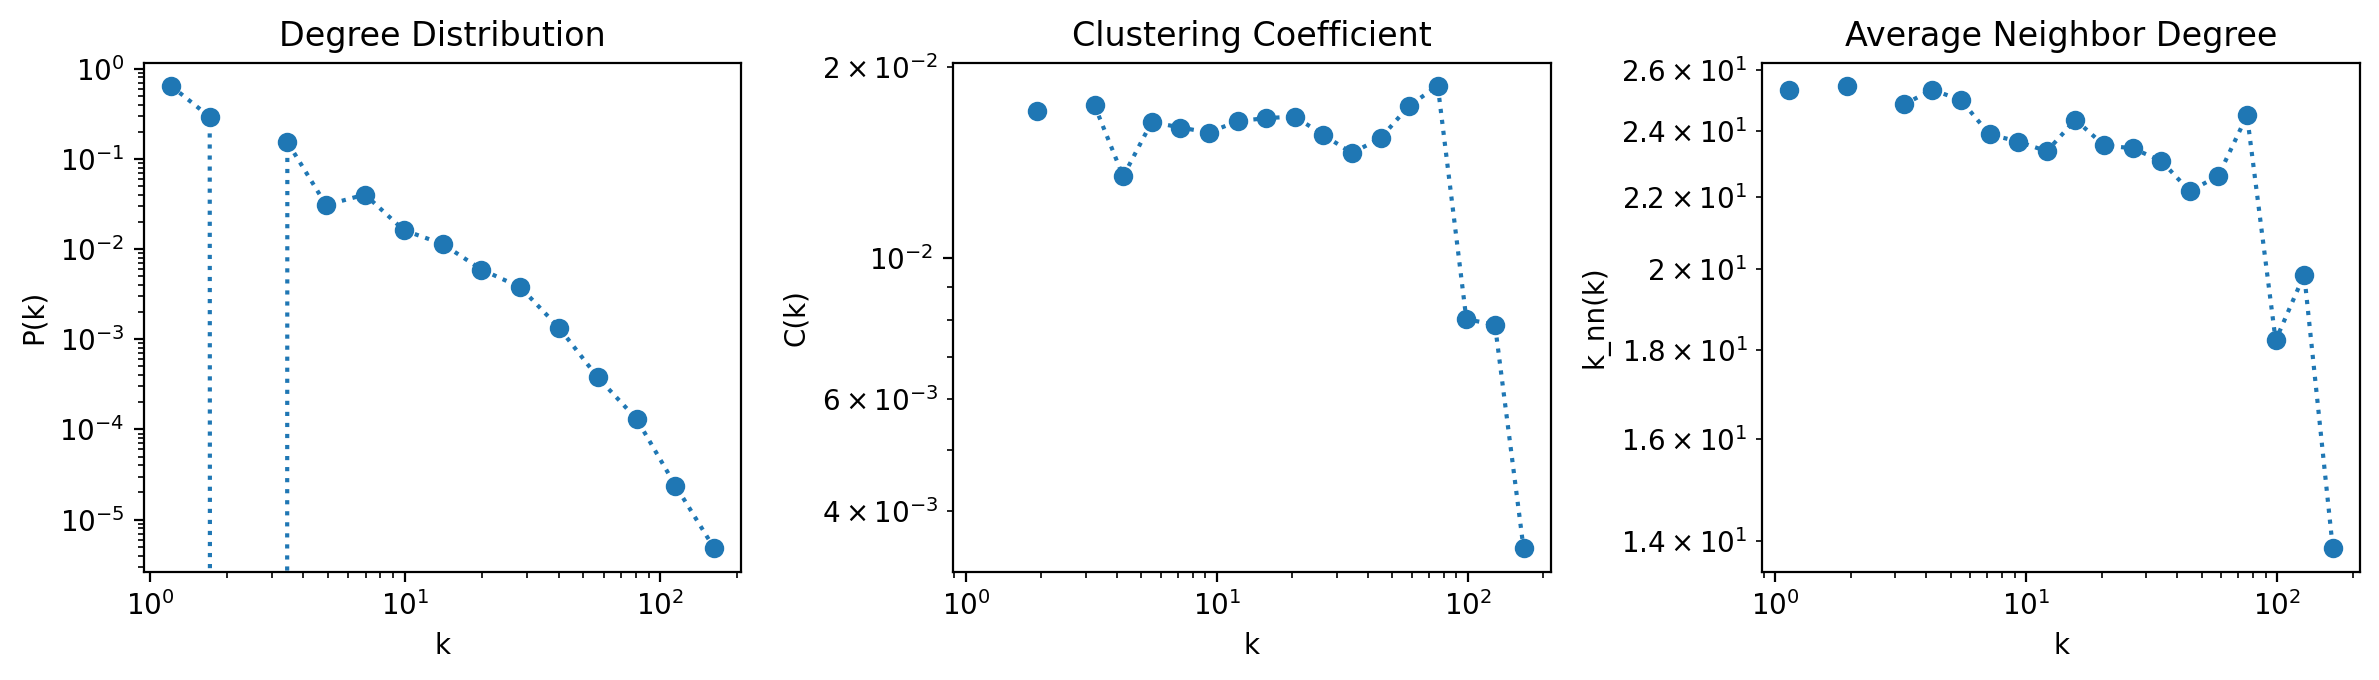

In [72]:
clustering_k = average_clustering_by_degree(G)
knn_k = average_neighbor_degree_by_degree(G)

number_of_bins = 20

X_clustering, Y_clustering = log_binning_function(list(clustering_k.keys()), list(clustering_k.values()), number_of_bins, "centre")
X_knn, Y_knn = log_binning_function(list(knn_k.keys()), list(knn_k.values()), number_of_bins, "centre")

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3.5),dpi=200)

plot_titles = ['Degree Distribution',
               'Clustering Coefficient',
               'Average Neighbor Degree']

y_axes = ['P(k)', 'C(k)', 'k_nn(k)']

ax1.plot(*degree_distribution(G), 'o', ls=':')
ax2.plot(X_clustering, Y_clustering, 'o', ls=':')
ax3.plot(X_knn, Y_knn, 'o', ls=':')

for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.set_title(plot_titles[i])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('k')
    ax.set_ylabel(y_axes[i])
plt.xlabel('k')

plt.tight_layout()
plt.savefig('images/three_distributions_original.pdf', bbox_inches='tight')
plt.show()

Plots for the randomized network:

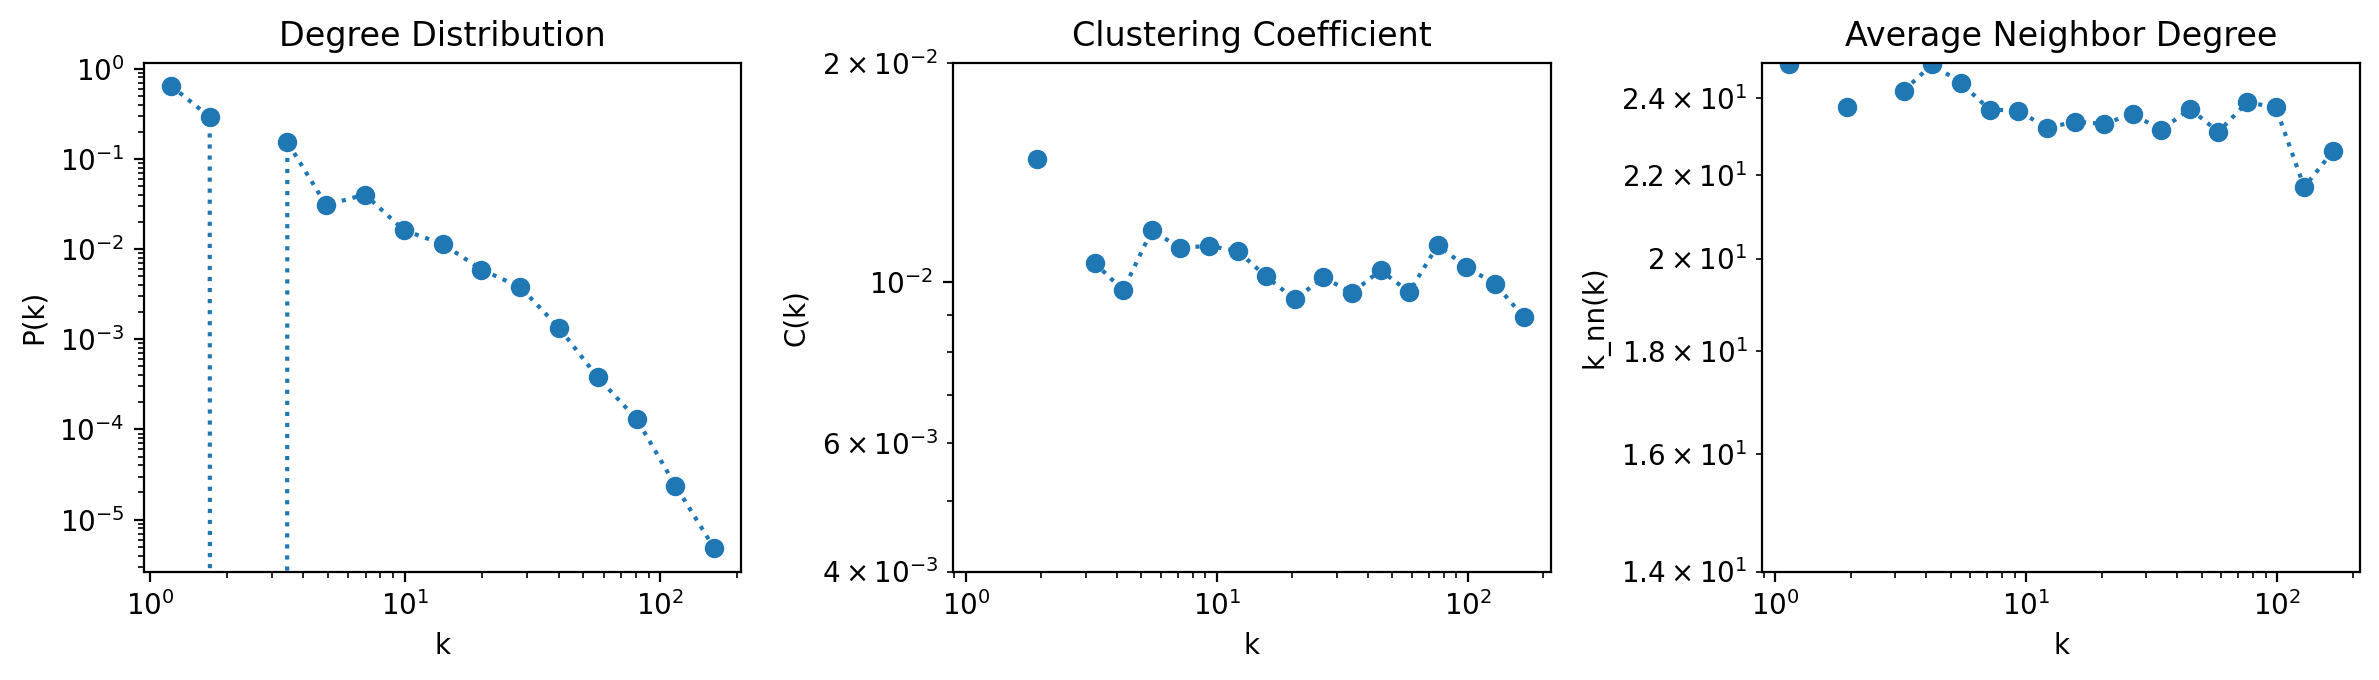

In [75]:
clustering_k_randomized = average_clustering_by_degree(G_randomized)
knn_k_randomized = average_neighbor_degree_by_degree(G_randomized)

number_of_bins = 20

X_clustering_randomized, Y_clustering_randomized = log_binning_function(list(clustering_k_randomized.keys()), list(clustering_k_randomized.values()), number_of_bins, "centre")
X_knn_randomized, Y_knn_randomized = log_binning_function(list(knn_k_randomized.keys()), list(knn_k_randomized.values()), number_of_bins, "centre")

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3.5),dpi=200)

plot_titles = ['Degree Distribution',
               'Clustering Coefficient',
               'Average Neighbor Degree']

y_axes = ['P(k)', 'C(k)', 'k_nn(k)']

ax1.plot(*degree_distribution(G_randomized), 'o', ls=':')
ax2.plot(X_clustering_randomized, Y_clustering_randomized, 'o', ls=':')
ax3.plot(X_knn_randomized, Y_knn_randomized, 'o', ls=':')

for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.set_title(plot_titles[i])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('k')
    ax.set_ylabel(y_axes[i])

ax2.set_ylim(4*10**(-3) , 2*10**(-2))    
ax3.set_ylim(1.4*10**1 , 2.5*10**1)

plt.tight_layout()
plt.savefig('images/three_distributions_randomized.pdf', bbox_inches='tight')
plt.show()

## Draft: